In [238]:
import pandas as pd
import numpy as np
import paths as pt
from pathlib import Path
from sksurv.linear_model.coxph import BreslowEstimator
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
from sklearn.model_selection import train_test_split
from utility.training import get_data_loader, scale_data, make_time_event_split
from utility.survival import survival_probability_calibration
from utility.model import load_mlp_model, load_sota_model, load_vi_model, load_mcd_model
from utility.survival import get_breslow_survival_times
from collections import defaultdict
import seaborn as sns

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

DATASET_NAME = "WHAS500"
RUNS = {'MLP': 1, 'VI': 100, 'MCD': 100}

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

In [245]:
# Load data
dl = get_data_loader(DATASET_NAME).load_data()
X, y = dl.get_data()
num_features, cat_features = dl.get_features()

# Split data in train, valid and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
                                                    random_state=0)

# Scale data
X_train, X_test = scale_data(X_train, X_test, cat_features, num_features)
X_train = np.array(X_train)
X_test = np.array(X_test)

# Make time/event split
t_train, e_train = make_time_event_split(y_train)
t_test, e_test = make_time_event_split(y_test)

# Fit Breslow to get event times
cox_model = load_sota_model(DATASET_NAME, "Cox")
train_predictions = cox_model.predict(X_train)
breslow = BreslowEstimator().fit(train_predictions, e_train, t_train)
event_times = breslow.unique_times_
    
# Calculate quantiles
percentiles = dict()
for q in [25, 50, 75, 90]:
    t = int(np.percentile(event_times, q))
    t_nearest = find_nearest(event_times, t)
    percentiles[q] = t_nearest

# Load models
n_input_dims = X_train.shape[1:]
n_train_samples = X_train.shape[0]
rsf_model = load_sota_model(DATASET_NAME, "RSF")
mlp_model = load_mlp_model(DATASET_NAME, n_input_dims)
vi_model = load_vi_model(DATASET_NAME, n_train_samples, n_input_dims)
mcd_model = load_mcd_model(DATASET_NAME, n_input_dims)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.


In [243]:
pred_obs, predictions, deltas = defaultdict(dict), defaultdict(dict), defaultdict(dict)
models = {'Cox': cox_model, 'RSF': rsf_model, 'MLP':mlp_model, 'VI': vi_model, 'MCD': mcd_model}
for t0 in percentiles.values():
    for model_name, model in models.items():
        if type(model).__name__ in ["CoxPHSurvivalAnalysis", "RandomSurvivalForest"]:
            surv_fn = model.predict_survival_function(X_test)
            surv_preds = pd.DataFrame(np.row_stack([fn(event_times) for fn in surv_fn]), columns=event_times)
        else:
            surv_fn = get_breslow_survival_times(model, X_train, X_test, e_train, t_train,
                                                    event_times, RUNS[model_name])
            surv_preds = pd.DataFrame(np.mean(surv_fn, axis=1), columns=event_times)
        pred_t0, obs_t0, predictions_at_t0, deltas_t0 = survival_probability_calibration(surv_preds, t_test, e_test, t0)
        pred_obs[t0][model_name] = (pred_t0, obs_t0)
        predictions[t0][model_name] = predictions_at_t0
        deltas[t0][model_name] = deltas_t0

X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
divide by zero encountered in log
invalid value encountered in subtract
X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
divide by zero encountered in log
divide by zero encountered in log
X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
divide by zero encountered in log
invalid value encountered in subtract
X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
divide by zero encountered in log
invalid value encountered in subtract
X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
divide by zero encountered in log
divide by zero encountere

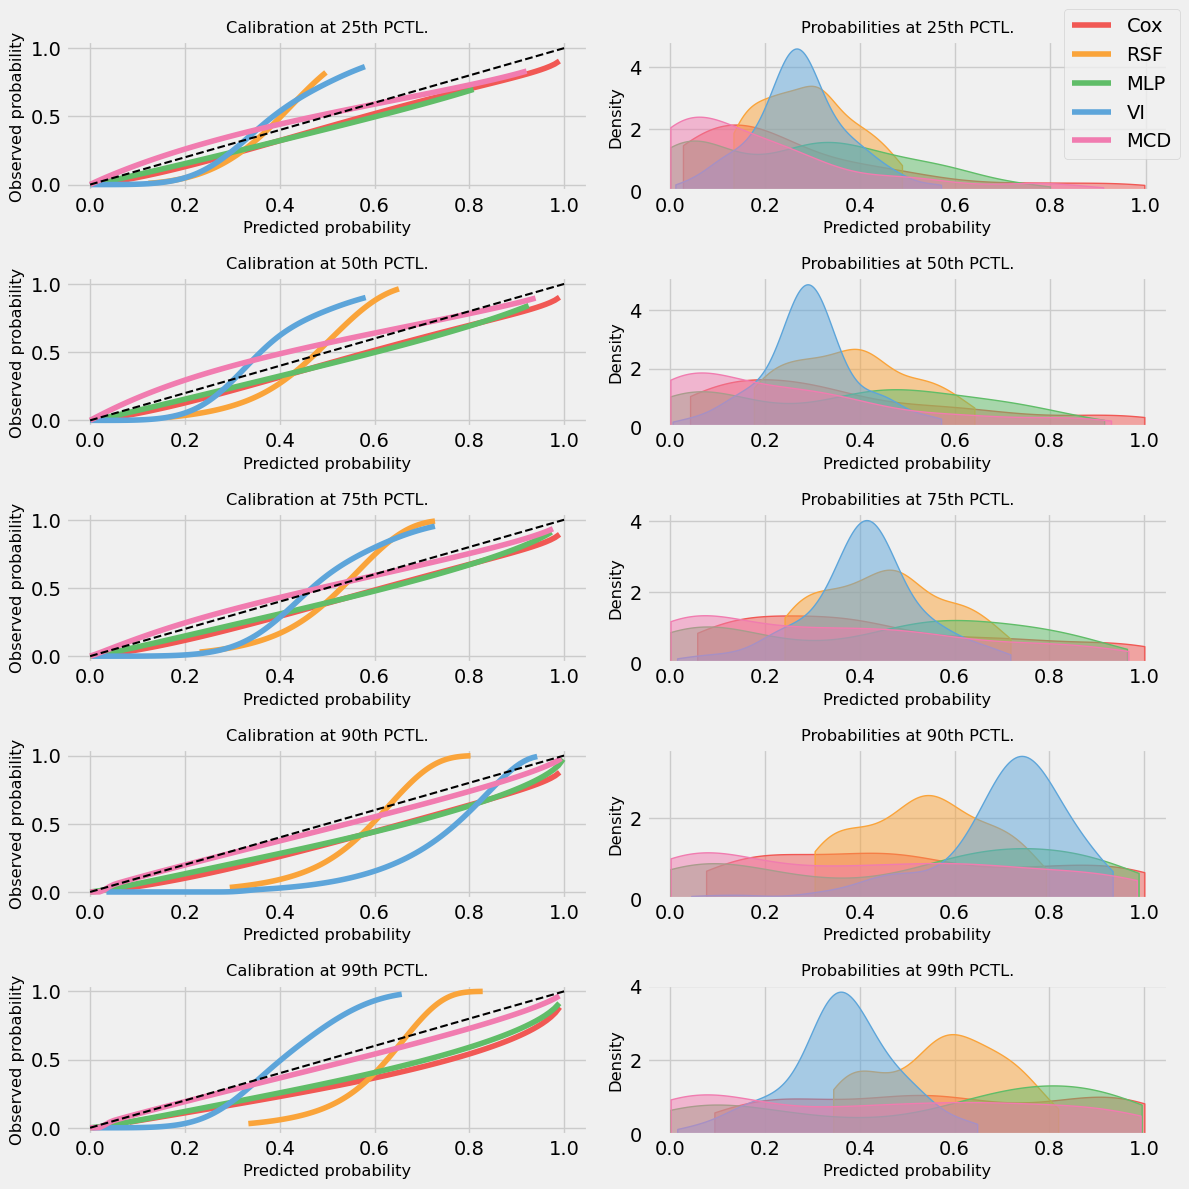

In [244]:
# plot our results
fig, axes = plt.subplots(4, 2, figsize=(12, 12))
labels = list()
plt.rcParams.update({'axes.labelsize': 'small',
                     'axes.titlesize': 'small'})
for i, (q, pctl) in enumerate(percentiles.items()):
    for model_idx, model_name in enumerate(['Cox', 'RSF', 'MLP', 'VI', 'MCD']):
        pred = pred_obs[pctl][model_name][0]
        obs = pred_obs[pctl][model_name][1]
        preds = predictions[pctl][model_name]
        data = pd.DataFrame({'Pred': pred, 'Obs': obs})
        axes[i][0].set_xlabel("Predicted probability")
        axes[i][1].set_xlabel("Predicted probability")
        axes[i][0].set_ylabel("Observed probability")
        axes[i][0].set_title(f"Calibration at th PCTL.")
        axes[i][0].set_title(f"Calibration at {q}th PCTL.")
        axes[i][1].set_title(f"Probabilities at {q}th PCTL.")
        sns.lineplot(data, x='Pred', y='Obs', color=TFColor[model_idx], ax=axes[i][0], legend=False, label=f"{model_name}")
        sns.kdeplot(preds, fill=True, common_norm=True, alpha=.5, cut=0, linewidth=1, color=TFColor[model_idx], ax=axes[i][1])
    ax=axes[i][0].plot([0, 1], [0, 1], c="k", ls="--", linewidth=1.5)
fig.tight_layout()
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.savefig(Path.joinpath(pt.RESULTS_DIR, f"{DATASET_NAME.lower()}_calibration.pdf"),
            format='pdf', bbox_inches="tight")
plt.grid(True)
plt.show()
plt.close()